In [ ]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


# !ls "/content/drive/My Drive"

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class UNet3D(nn.Module):
    def __init__(self, base_ch=16):
        super().__init__()

        self.enc1 = DoubleConv(1, base_ch)
        self.enc2 = DoubleConv(base_ch, base_ch*2)
        self.enc3 = DoubleConv(base_ch*2, base_ch*4)
        self.enc4 = DoubleConv(base_ch*4, base_ch*8)

        self.pool = nn.MaxPool3d(2)

        self.bottleneck = DoubleConv(base_ch*8, base_ch*16)

        self.up4 = nn.ConvTranspose3d(base_ch*16, base_ch*8, 2, stride=2)
        self.dec4 = DoubleConv(base_ch*16, base_ch*8)

        self.up3 = nn.ConvTranspose3d(base_ch*8, base_ch*4, 2, stride=2)
        self.dec3 = DoubleConv(base_ch*8, base_ch*4)

        self.up2 = nn.ConvTranspose3d(base_ch*4, base_ch*2, 2, stride=2)
        self.dec2 = DoubleConv(base_ch*4, base_ch*2)

        self.up1 = nn.ConvTranspose3d(base_ch*2, base_ch, 2, stride=2)
        self.dec1 = DoubleConv(base_ch*2, base_ch)

        self.out = nn.Conv3d(base_ch, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.out(d1)

In [ ]:
device = "cuda"

model = UNet3D(base_ch=16).to(device)
ckpt = torch.load("/content/drive/MyDrive/unet3d_fault.pth", map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()


UNet3D(
  (enc1): DoubleConv(
    (net): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (net): Sequential(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (net): Sequential(
      (0):

In [ ]:
import os
TRAIN_DIR = "/content/drive/MyDrive/train"
VAL_DIR   = "/content/drive/MyDrive/validation"

train_files = sorted([os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if f.endswith(".npz")])
val_files   = sorted([os.path.join(VAL_DIR, f)   for f in os.listdir(VAL_DIR)   if f.endswith(".npz")])

In [ ]:
import numpy as np

file = train_files[0]
data = np.load(file)

seis = data["seis"]
fault_gt = data["fault"]


In [ ]:
import torch

ps = 64
stride = 32  # overlap is important

D, H, W = seis.shape
pred_volume = np.zeros((D, H, W), dtype=np.float32)
count_volume = np.zeros((D, H, W), dtype=np.float32)

with torch.no_grad():
    for d in range(0, D - ps + 1, stride):
        for h in range(0, H - ps + 1, stride):
            for w in range(0, W - ps + 1, stride):

                patch = seis[d:d+ps, h:h+ps, w:w+ps]
                patch = torch.tensor(patch, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

                pred = model(patch)
                pred = torch.sigmoid(pred).squeeze().cpu().numpy()

                pred_volume[d:d+ps, h:h+ps, w:w+ps] += pred
                count_volume[d:d+ps, h:h+ps, w:w+ps] += 1


In [ ]:
pred_volume /= np.maximum(count_volume, 1)


In [ ]:
pred_fault = (pred_volume > 0.5).astype(np.uint8)


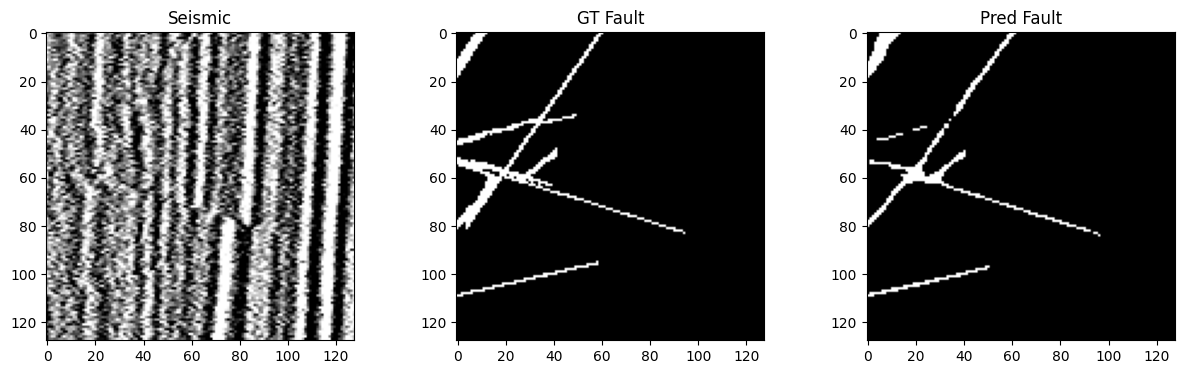

In [ ]:
import matplotlib.pyplot as plt

idx = D // 2

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.title("Seismic")
plt.imshow(seis[idx], cmap="gray")

plt.subplot(1,3,2)
plt.title("GT Fault")
plt.imshow(fault_gt[idx], cmap="gray")

plt.subplot(1,3,3)
plt.title("Pred Fault")
plt.imshow(pred_fault[idx], cmap="gray")

plt.show()


In [ ]:

file_path = "/content/drive/MyDrive/prediction/f3d/gxl.dat"
print("File size (bytes):", os.path.getsize(file_path))


File size (bytes): 100663296


In [ ]:
import numpy as np

D, H, W = 512, 384, 128

seis = np.fromfile(file_path, dtype=np.float32)
seis = seis.reshape(D, H, W)


In [ ]:
seis = (seis - seis.mean()) / (seis.std() + 1e-6)


In [ ]:
ps = 64
stride = 32

D, H, W = seis.shape
pred_volume = np.zeros((D, H, W), dtype=np.float32)
count_volume = np.zeros((D, H, W), dtype=np.float32)

import torch

with torch.no_grad():
    for d in range(0, D - ps + 1, stride):
        for h in range(0, H - ps + 1, stride):
            for w in range(0, W - ps + 1, stride):

                patch = seis[d:d+ps, h:h+ps, w:w+ps]
                patch = torch.tensor(patch, dtype=torch.float32)\
                              .unsqueeze(0).unsqueeze(0).to(device)

                pred = model(patch)
                pred = torch.sigmoid(pred).squeeze().cpu().numpy()

                pred_volume[d:d+ps, h:h+ps, w:w+ps] += pred
                count_volume[d:d+ps, h:h+ps, w:w+ps] += 1

pred_volume /= np.maximum(count_volume, 1)


In [ ]:
pred_fault = (pred_volume > 0.4).astype(np.uint8)


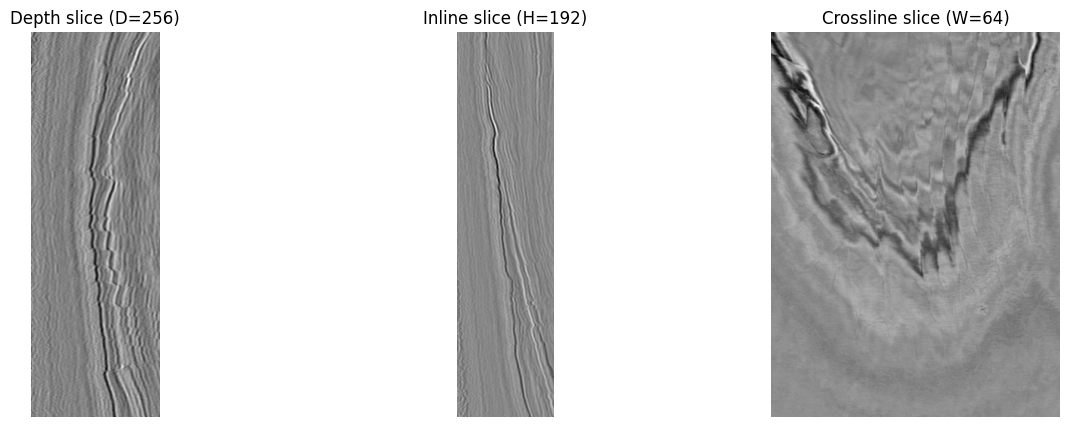

In [ ]:
import matplotlib.pyplot as plt

d_idx = D // 2
h_idx = H // 2
w_idx = W // 2

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title(f"Depth slice (D={d_idx})")
plt.imshow(seis[d_idx, :, :], cmap="gray")
plt.axis("off")

plt.subplot(1,3,2)
plt.title(f"Inline slice (H={h_idx})")
plt.imshow(seis[:, h_idx, :], cmap="gray")
plt.axis("off")

plt.subplot(1,3,3)
plt.title(f"Crossline slice (W={w_idx})")
plt.imshow(seis[:, :, w_idx], cmap="gray")
plt.axis("off")

plt.show()


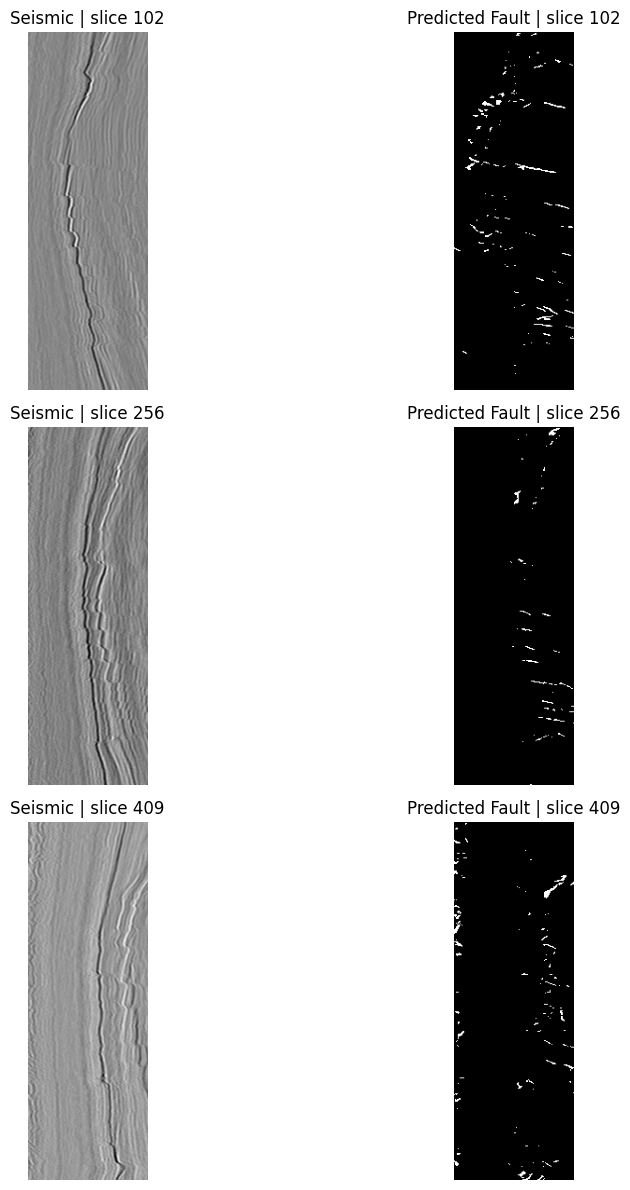

In [ ]:
import matplotlib.pyplot as plt

indices = [D // 5, D // 2, (4 * D) // 5]

plt.figure(figsize=(12, 4 * len(indices)))

for i, idx in enumerate(indices):
    plt.subplot(len(indices), 2, 2*i + 1)
    plt.title(f"Seismic | slice {idx}")
    plt.imshow(seis[idx], cmap="gray")
    plt.axis("off")

    plt.subplot(len(indices), 2, 2*i + 2)
    plt.title(f"Predicted Fault | slice {idx}")
    plt.imshow(pred_fault[idx], cmap="gray")
    plt.axis("off")

plt.tight_layout()
plt.show()
